In [290]:
import requests
import json
import pandas as pd
import tqdm
import time
import numpy as np
from scipy import spatial
import scipy as sc
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings("ignore")
import random

In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns           
%matplotlib inline

In [3]:
def lastfm_get(payload):
    # define headers and URL
    headers = {'user-agent': 'EDU_PROJECT'}      # здесь впишите что-нибудь другое, если начнут банить аккаунты - 
                                                 # могут всех скопом с таким user-agent'ом подбанить :)
    url = 'https://ws.audioscrobbler.com/2.0/'

    # Add API key and format to the payload
    payload['api_key'] = 'a18850b469ecb6fa86579fb399e96b9b' # подставить свой апи ключ
    payload['format'] = 'json'

    response = requests.get(url, headers=headers, params=payload)
    return response

In [89]:
t1 = lastfm_get({
    'artist' : 'Megadeth',
    'method': 'artist.getTopTags'
    })
t1.json()

{'toptags': {'tag': [{'count': 100,
    'name': 'thrash metal',
    'url': 'https://www.last.fm/tag/thrash+metal'},
   {'count': 51,
    'name': 'heavy metal',
    'url': 'https://www.last.fm/tag/heavy+metal'},
   {'count': 43, 'name': 'metal', 'url': 'https://www.last.fm/tag/metal'},
   {'count': 31,
    'name': 'speed metal',
    'url': 'https://www.last.fm/tag/speed+metal'},
   {'count': 19,
    'name': 'seen live',
    'url': 'https://www.last.fm/tag/seen+live'},
   {'count': 14, 'name': 'thrash', 'url': 'https://www.last.fm/tag/thrash'},
   {'count': 6,
    'name': 'hard rock',
    'url': 'https://www.last.fm/tag/hard+rock'},
   {'count': 5, 'name': 'rock', 'url': 'https://www.last.fm/tag/rock'},
   {'count': 5, 'name': 'american', 'url': 'https://www.last.fm/tag/american'},
   {'count': 4, 'name': 'Megadeth', 'url': 'https://www.last.fm/tag/Megadeth'},
   {'count': 3, 'name': '80s', 'url': 'https://www.last.fm/tag/80s'},
   {'count': 2,
    'name': 'trash metal',
    'url': 'http

Подгружаем теги по каждому исполнителю - часто в них "зашита" информация по жанрам, в которых данный исполнитель создает музыку

In [96]:
def get_artist_tags(artists, tag_num):
    df = pd.DataFrame(columns = ['artist', 'tags'])
    for ar in tqdm.tqdm(artists):
        try:
            tags = []
            t1 = lastfm_get({
            'artist' : ar,
            'method': 'artist.getTopTags'})
            data = t1.json()['toptags']['tag']
            ln = min(tag_num, len(data))
            for i in range(ln):
                tags.append(data[i]['name'])
                res = ', '.join(tags)
            df.loc[len(df)] = [ar, res]
        except Exception:
            print('Error occured on string:', ar)
            df.loc[len(df)] = [ar, np.nan]
            continue
    return df

In [99]:
tags = get_artist_tags(art, 5)

100%|████████████████████████████████████████████████████████████████████████████| 11226/11226 [49:12<00:00,  3.80it/s]


In [101]:
tags.to_csv('tag.csv', index=False)

In [5]:
pd.read_csv('tag.csv').head(20)

,artist,tags
0,Radiohead,"alternative, alternative rock, rock, indie, el..."
1,Boards of Canada,"ambient, electronic, idm, electronica, chillout"
2,Interpol,"indie, indie rock, post-punk, seen live, alter..."
3,The National,"seen live, indie rock, indie, alternative, rock"
4,Burial,"dubstep, electronic, ambient, experimental, el..."
5,Aphex Twin,"electronic, idm, ambient, experimental, electr..."
6,Arctic Monkeys,"indie rock, indie, british, rock, alternative"
7,Nine Inch Nails,"industrial, industrial rock, rock, alternative..."
8,Animal Collective,"experimental, indie, freak folk, seen live, in..."
9,Bon Iver,"folk, indie, singer-songwriter, acoustic, seen..."


In [34]:
dft = pd.read_csv('df_test.csv', index_col=0)

In [35]:
df = pd.read_csv('df_train.csv', index_col=0)

In [36]:
rdf = pd.concat([df, dft]).reset_index(drop=True)

In [37]:
tags = pd.read_csv('tag.csv')

### Preparing data
#### Приведение типов, удаление лишних столбцов, очистка по условию "используем лишь песни, которые прослушало минимум 2 пользователя

In [4]:
def clean_dataset(df):
    df['rank'] = df['rank'].astype(int)
    df['rating'] = (101 - df['rank'])/100
    df = df.loc[df['rating'] > 0.5].reset_index(drop=True)
    df['song_name'] = [str(x)[:40] for x in list(df['artist_song'])]
    df = df[['login', 'rating', 'song_name', 'artist', 'count']]
    df = df.drop_duplicates().reset_index(drop=True)
    ex_logins = df.loc[(df['rating'] > 0.5) & (df['count'] == 1)]['login']
    dct = dict(df['song_name'].value_counts())
    print(df.shape)
    print(len(ex_logins))
    df = df[~df.login.isin(ex_logins)]
    print(df.shape)
    return df.reset_index(drop=True)

In [40]:
df = clean_dataset(rdf)

(503700, 5)
5415
(503700, 5)
(493700, 5)
(493700, 5)


In [41]:
df.artist.value_counts()

Radiohead             4113
Boards of Canada      2641
Interpol              2291
Burial                1784
The National          1750
                      ... 
David Pagmar             1
Cultural Amnesia         1
Michael Cera Palin       1
Band of Pain             1
Tom Zanetti              1
Name: artist, Length: 62101, dtype: int64

In [42]:
cnt = 0
dd = dict(df.artist.value_counts())
for d in dd:
    if dd[d] > 1:
        cnt += 1
        
print(cnt)

29002


In [43]:
udf = df.merge(tags, how='left', left_on='artist', right_on='artist')

In [44]:
del df
del rdf
del dft

#### Песни с самым высоким рейтингом (независимо от количества оценок)

In [45]:
udf.groupby('song_name')['rating'].mean().sort_values(ascending=False).head()

song_name
The Books -- You'll Never Be Alone     1.0
[unknown] -- Pista 3                   1.0
Robert Pattinson -- Bella's Lullaby    1.0
Robert Pattinson -- Bella's Song       1.0
Robert Pattinson -- Bella's_Lullaby    1.0
Name: rating, dtype: float64

#### Самые часто встречающиеся песни

In [46]:
udf.groupby('song_name')['rating'].count().sort_values(ascending=False).head()

song_name
Bon Iver -- Skinny Love                    263
Burial -- Archangel                        251
Joy Division -- Love Will Tear Us Apart    235
The xx -- Crystalised                      214
Radiohead -- Reckoner                      206
Name: rating, dtype: int64

In [47]:
u_means = pd.DataFrame(udf.groupby('song_name')['rating'].mean().reset_index())

In [48]:
u_means['rating_counts'] = list(udf.groupby('song_name')['rating'].count())

<AxesSubplot:>

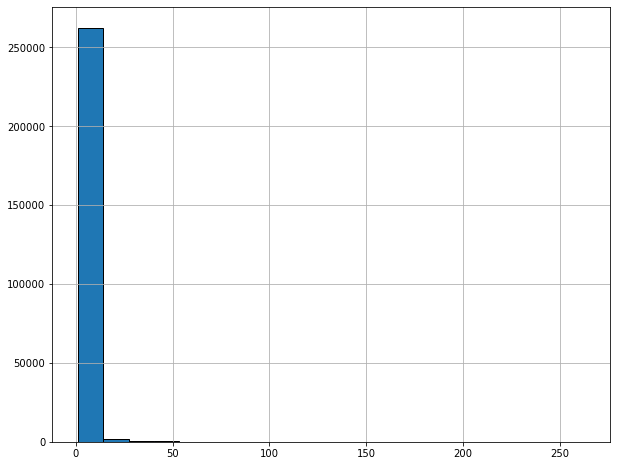

In [50]:
plt.figure(figsize=(10,8))
plt.rcParams['patch.force_edgecolor'] = True
u_means['rating_counts'].hist(bins=20)

#### Подавляющее число оценок песен находится ниже 50 шт (т.е. 50 и менее пользователей оценило песню)

<AxesSubplot:>

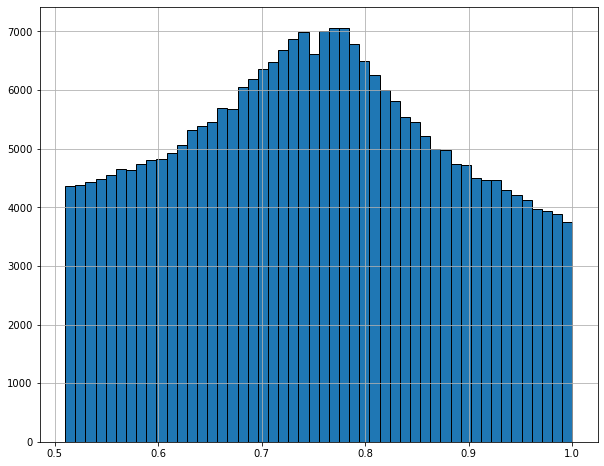

In [51]:
plt.figure(figsize=(10,8))
plt.rcParams['patch.force_edgecolor'] = True
u_means['rating'].hist(bins=50)

#### Распределение оценок после очистки данных - песен, которые встречаются лишь однажды

<Figure size 720x576 with 0 Axes>

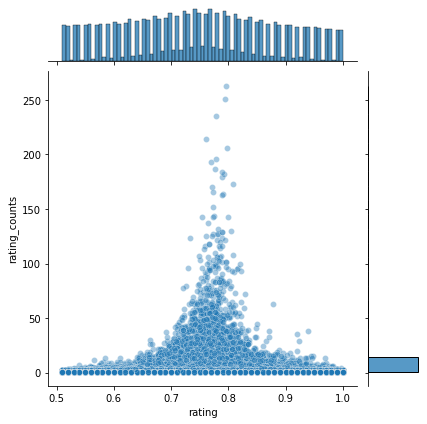

In [52]:
plt.figure(figsize=(10,8))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=u_means, alpha=0.4)

In [53]:
udf.artist.value_counts().head(50)

Radiohead              4113
Boards of Canada       2641
Interpol               2291
Burial                 1784
The National           1750
Bon Iver               1499
The xx                 1479
Aphex Twin             1422
Nine Inch Nails        1403
Arctic Monkeys         1382
Animal Collective      1363
Joy Division           1314
The Smiths             1261
Massive Attack         1231
David Bowie            1219
Pink Floyd             1210
Depeche Mode           1143
Arcade Fire            1109
Beach House            1084
my bloody valentine    1028
Coldplay                994
Muse                    992
The Cure                987
The Beatles             939
Elliott Smith           881
Portishead              875
Crystal Castles         867
Daft Punk               833
Beirut                  830
Air                     814
Autechre                804
Kanye West              803
Sufjan Stevens          800
The Knife               791
Lana Del Rey            783
Bob Dylan           

#### Выше указаны самые часто оцениваемые исполнители среди пользователей

In [126]:
def make_pivot(df):
    users = pd.unique(df.login)
    sdict = dict()
    songs = list(pd.unique(df.song_name))
    for i in range(len(songs)):
        sdict[songs[i]] = i
    res_df = pd.DataFrame(columns = ['login'] + list(range(len(songs))))
    print(res_df.shape)
    for user in tqdm.tqdm(users):
        tempdf = df.loc[df.login == user]
        urow = [user] + (len(songs)) * [0]
        print(len(urow))
        print(len(songs))
        for index, row in tempdf.iterrows():
            urow[sdict[row['song_name']] + 1] = row['rating']
        res_df.loc[len(res_df)] = urow
    return res_df, sdict

#### С помощью функции выше кодируем исполнителей, пользователей и песни для "облегченного" представления таблицы

In [54]:
user_index = pd.DataFrame(columns = ['login'], data = pd.unique(udf['login']))
user_index['user_id'] = user_index.index
user_index

,login,user_id
0,AceCrikey,0
1,AcidFeelings,1
2,AcidMotherT-le,2
3,Acidart,3
4,Acribia,4
...,...,...
9869,yelizwho,9869
9870,yenpox,9870
9871,yerbahydris,9871
9872,yesjohnterry,9872


In [55]:
user_index.to_csv('u_index.csv', index=False)

In [56]:
song_index = pd.DataFrame(columns = ['song_name'], data = pd.unique(udf['song_name']))
song_index['song_id'] = song_index.index
song_index

,song_name,song_id
0,Stackridge -- The Volunteer,0
1,Sparks -- Here In Heaven,1
2,Stackridge -- Spin Around The Room,2
3,Stackridge -- Happy in the Lord,3
4,Stackridge -- Highbury Incident,4
...,...,...
265355,Tweaker -- Ruby,265355
265356,Butthole Surfers -- Intelligent Guy,265356
265357,"Mallu Magalhães -- ô, Ana",265357
265358,Sheryl Crow -- Real Gone,265358


In [57]:
song_index.to_csv('s_index.csv', index=False)

In [58]:
art_index = pd.DataFrame(columns = ['artist'], data = pd.unique(udf['artist']))
art_index['artist_id'] = art_index.index
art_index

,artist,artist_id
0,Stackridge,0
1,Sparks,1
2,That Fucking Tank,2
3,Porcupine Tree,3
4,Wild Beasts,4
...,...,...
62096,ליהי עטר,62096
62097,Ôëŕézzzŕ,62097
62098,Kate Nash/Lethal Bizzle,62098
62099,KaaK,62099


In [59]:
art_index.to_csv('a_index.csv', index=False)

In [152]:
udf.to_csv('user-songs.csv', index=False)

In [153]:
df_user = udf.merge(user_index, how='inner', left_on='login', right_on='login')
df_user_song = df_user.merge(song_index, how='inner', left_on='song_name', right_on='song_name')
df_user_song_art = df_user_song.merge(art_index, how='inner', left_on='artist', right_on='artist')

In [155]:
pdf = df_user_song_art[['rating', 'user_id', 'song_id', 'artist_id']]

In [156]:
pdf.to_csv('pivot_df.csv', index=False)

In [1]:
import pandas as pd

In [7]:
pdf = pd.read_csv('pivot_df.csv')

Вся таблица с оценками приведена к следующему виду :

In [3]:
pdf

,rating,user_id,song_id,artist_id
0,1.00,0,0,0
1,0.98,0,2,0
2,0.97,0,3,0
3,0.96,0,4,0
4,0.94,0,6,0
...,...,...,...,...
493695,0.66,9873,244462,58687
493696,0.62,9873,244463,58688
493697,0.60,9873,244464,58689
493698,0.59,9873,244465,58690


In [4]:
p = pdf.loc[pdf.user_id < 4000].reset_index(drop=True)

In [5]:
pivot_table = p.pivot_table(values='rating', index='user_id', columns='song_id')

In [6]:
pivot_table

song_id,0,1,2,3,4,5,6,7,8,9,...,252966,252967,252968,252969,252970,252971,252972,252973,252974,252975
user_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.76,NaN,NaN,NaN,NaN
3996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.82,NaN,NaN,NaN


In [7]:
pivot_table.to_csv('pivot_song.csv', index=False)

### Реализуем два item-based подхода :
####    1. Popularity Based Filtering

Используем формулу взвешенного среднего (WR)=[vR/(v+m)]+[mC/(v+m)]

v - количество оценок песни
m - необходимый минимум оценок для включения в список
R - средний рейтинг песни
C - среднее по всему списку оценок

In [17]:
C = pdf['rating'].mean()
C

0.7550000000000097

In [18]:
m = pd.Series(pdf.song_id.value_counts().values).quantile(0.95)
m

5.0

In [27]:
dct = dict(pdf.song_id.value_counts())
wdict = {} # словарь песен и количества оценок
for k in dct:
    if dct[k] >= 5:
        wdict[k] = dct[k]
print(len(wdict))

15029


Нашу оценку получит 15029 песен

In [28]:
edict = dict() # словарь средних оценок
for k in wdict:
    edict[k] = round(pdf.loc[pdf.song_id == k]['rating'].mean(), 3)
print(len(edict))

15029


#### Создадим фрейм взвешенных оценок

In [47]:
def calc_weighted_rating(v, R, m, C):
    return (v/(v+m) * R) + (m/(m+v) * C)

Загрузим словарь расшифровки artist - song

In [42]:
sname = pd.read_csv('s_index.csv')

In [43]:
sname

,song_name,song_id
0,Stackridge -- The Volunteer,0
1,Sparks -- Here In Heaven,1
2,Stackridge -- Spin Around The Room,2
3,Stackridge -- Happy in the Lord,3
4,Stackridge -- Highbury Incident,4
...,...,...
265355,Tweaker -- Ruby,265355
265356,Butthole Surfers -- Intelligent Guy,265356
265357,"Mallu Magalhães -- ô, Ana",265357
265358,Sheryl Crow -- Real Gone,265358


In [45]:
sname.to_dict()['song_name'][0]

'Stackridge -- The Volunteer'

In [54]:
wr = pd.DataFrame(columns = ['song_id', 'song_artist', 'score'])
for s in tqdm.tqdm(edict):
    score = calc_weighted_rating(wdict[s], edict[s], m, C)
    song_artist = sname.to_dict()['song_name'][s]
    wr.loc[len(wr)] = [s, song_artist, score]
wr

100%|████████████████████████████████████████████████████████████████████████████| 15029/15029 [23:25<00:00, 10.70it/s]


,song_id,song_artist,score
0,5044,Bon Iver -- Skinny Love,0.795235
1,630,Burial -- Archangel,0.794219
2,3437,Joy Division -- Love Will Tear Us Apart,0.778500
3,3411,The xx -- Crystalised,0.759886
4,796,Radiohead -- Reckoner,0.796981
...,...,...,...
15024,3714,Alice in Chains -- Junkhead,0.727500
15025,69165,Pet Shop Boys -- Being Boring,0.762500
15026,101997,Purity Ring -- bodyache,0.762500
15027,61885,Pantera -- I'm Broken,0.717500


In [56]:
wr.sort_values(by='score', ascending=False).head(25)

,song_id,song_artist,score
528,4238,The Moon Lay Hidden Beneath a Cloud -- U,0.917605
3415,19769,I Waiting For You Last Summer -- Nevermo,0.908833
2760,19771,I Waiting For You Last Summer -- And not,0.899750
612,4239,Der Blutharsch -- Untitled,0.898500
856,452,William Basinski -- Untitled,0.898294
2568,15877,I Waiting For You Last Summer -- Sleep,0.897500
5661,9358,Avril Lavigne -- Hello Kitty,0.893857
3211,687,Teebs -- Untitled,0.893667
3178,15876,I Waiting For You Last Summer -- Event h,0.887889
1669,1301,Gas -- [untitled],0.887000


Text(0.5, 1.0, 'Popular Songs')

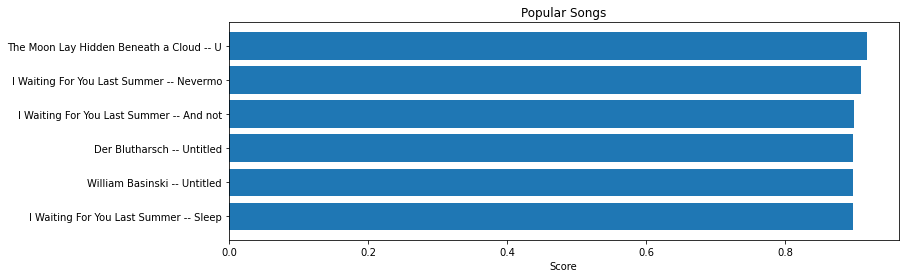

In [60]:
pop = wr.sort_values(by='score', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['song_artist'].head(6), pop['score'].head(6), align='center')
plt.gca().invert_yaxis()
plt.xlabel("Score")
plt.title("Popular Songs")

### Таким образом мы нашли Топ самых популярных песен, которые можно рекомендовать независимо от предпочтений новых пользователей

#### Часть 2. Поиск похожих артистов по оценкам пользователей через нахождение корреляций.

##### Загрузим ранее подготовленный фрейм user x artist

In [75]:
pa = pd.read_csv('pivot_artist.csv')

In [68]:
aname = pd.read_csv('a_index.csv') # загрузим справочник артистов
aname

,artist,artist_id
0,Stackridge,0
1,Sparks,1
2,That Fucking Tank,2
3,Porcupine Tree,3
4,Wild Beasts,4
...,...,...
62096,ליהי עטר,62096
62097,Ôëŕézzzŕ,62097
62098,Kate Nash/Lethal Bizzle,62098
62099,KaaK,62099


In [123]:
tags = pd.read_csv('tag.csv')
tags

,artist,tags
0,Radiohead,"alternative, alternative rock, rock, indie, el..."
1,Boards of Canada,"ambient, electronic, idm, electronica, chillout"
2,Interpol,"indie, indie rock, post-punk, seen live, alter..."
3,The National,"seen live, indie rock, indie, alternative, rock"
4,Burial,"dubstep, electronic, ambient, experimental, el..."
...,...,...
11221,Zurdok,"rock, rock mexicano, alternative, alternative ..."
11222,Jane Siberry,"female vocalists, Canadian, singer-songwriter,..."
11223,Quimby,"hungarian, alternative, seen live, alternative..."
11224,Attic Abasement,"Lo-Fi, hockey-core, folk, rare sad boy, emo"


In [379]:
def find_correlated_artists(df, tags, artist_num, aname):
    try:
        tags_art = tags.loc[tags['artist'] == aname.to_dict()['artist'][int(artist_num)]]['tags'].values.item().replace(' ','').split(',')
    except ValueError:
        print('There are no tags for artist. Skip')
        return [], 0
    print('Find correlation for group:', aname.to_dict()['artist'][int(artist_num)])
    print('Tags for group:', tags_art)
    resdf = pd.DataFrame(columns = ['artist_id', 'artist_name', 'correlation', 'tags'])
    corr = dict(df.corrwith(df[str(artist_num)]).dropna().sort_values(ascending=False).head(10))
    cnt = 0
    for k in corr:
        cnt += 1
        artist = aname.to_dict()['artist'][int(k)]
        tgs = list(tags.loc[tags['artist'] == artist]['tags'].values)
        if len(tgs) > 0:
            resdf.loc[len(resdf)] = [k, artist, corr[k], ''.join(tags.loc[tags['artist'] == artist]['tags'].values)]
        if cnt > 5:
            break
    return tags_art, resdf

In [380]:
def evaluate_precision(tags_inc, tags_eval):
    rstring = tags_eval.replace(',','').replace(' ', '')
    for tag in tags_inc:
        if rstring.find(tag) > -1:
            return 1
    return 0

In [381]:
def calc_prec_for_group(df, tags, artist_num, aname):
    tags_inc, rdf = find_correlated_artists(df, tags, artist_num, aname)
    if len(tags_inc) == 0 or len(rdf) == 0:
        return -1
    prec_list = []
    for index, row in rdf.iterrows():
        prec_list.append(evaluate_precision(list(tags_inc), row['tags']))
    return round(sum(prec_list)/len(prec_list), 2)

In [386]:
def calc_avg_prec_for_sample(df, tags, sample_size, aname):
    pool = []
    get_index = random.sample(list(tags.artist_id), sample_size)
    print('picked indexes:',get_index)
    for ind in get_index:
        try:
            res = calc_prec_for_group(df, tags, ind, aname)
            if res > -1:
                pool.append(res)
        except Exception:
            print('Error occured on ind', ind)
            continue
    prec = round(sum(pool)/len(pool), 2)
    print('============================\n============================')
    print('total sample size', len(pool))
    print('precision on sample:', prec)

In [ ]:
tags = tags.merge(aname, how='inner', left_on='artist', right_on='artist')

In [368]:
tags

,artist,tags,artist_id
0,Radiohead,"alternative, alternative rock, rock, indie, el...",336
1,Boards of Canada,"ambient, electronic, idm, electronica, chillout",70
2,Interpol,"indie, indie rock, post-punk, seen live, alter...",56
3,The National,"seen live, indie rock, indie, alternative, rock",918
4,Burial,"dubstep, electronic, ambient, experimental, el...",344
...,...,...,...
11168,Zurdok,"rock, rock mexicano, alternative, alternative ...",3392
11169,Jane Siberry,"female vocalists, Canadian, singer-songwriter,...",13808
11170,Quimby,"hungarian, alternative, seen live, alternative...",36606
11171,Attic Abasement,"Lo-Fi, hockey-core, folk, rare sad boy, emo",9937


In [387]:
calc_avg_prec_for_sample(pa, tags, 20, aname)

picked indexes: [57955, 11450, 10288, 2743, 25081, 9544, 27630, 6915, 46943, 2311, 14378, 12140, 20483, 3718, 1037, 3240, 52637, 47467, 930, 11687]
Find correlation for group: Orchestre Al BRIHI - Hadj Abdelkrim RAIS
Tags for group: ['Marruecos', 'nuba']
Error occured on ind 57955
Find correlation for group: Pegasus Bridge
Tags for group: ['indie', 'indierock', 'powerpop', 'rock', 'british']
Find correlation for group: The Seeds
Tags for group: ['GarageRock', '60s', 'PsychedelicRock', 'psychedelic', 'garage']
Find correlation for group: Jackson Browne
Tags for group: ['singer-songwriter', 'classicrock', 'rock', 'folk', 'softrock']
Find correlation for group: Chris Tomlin
Tags for group: ['christian', 'worship', 'contemporarychristian', 'christianrock', 'praiseandworship']
Find correlation for group: Brian Tyler
Tags for group: ['Soundtrack', 'composer', 'instrumental', 'score', 'composers']
Find correlation for group: Triángulo de Amor Bizarro
Tags for group: ['shoegaze', 'indie', 'ind

#### Точность определялась следующим образом :
##### Если один из жанровых тегов артиста совпадает с одним из жанров похожих артистов, ставится как точное определение "похожести". Для каждого артиста искали min(5, факт_найденных) похожих артистов и с каждым сравнивались жанры. Точность усреднялась по артисту и далее по сэмплу